<a href="https://colab.research.google.com/github/Isuru-rangana/Deep-Learning-Assignment/blob/Gayan/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



#test

In [ ]:
# Load the dataset from Google Drive
data = pd.read_csv('/content/drive/MyDrive/DL-projects/hour.csv')

In [ ]:
print(data.head())  # Check the first few rows of the dataset
print(data.info())  # Get an overview of the dataset (data types, missing values)
print(data.describe())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 

In [ ]:
#  Data preprocessing
# predict the 'cnt' (total rental bikes) and use weather and time features as inputs.

features = ['temp', 'atemp', 'hum', 'windspeed', 'season', 'holiday', 'weekday', 'workingday', 'weathersit', 'hr']
target = ['cnt']

In [ ]:
X = data[features].values  # Feature matrix
y = data[target].values  # Target variable

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))  # Normalize data between 0 and 1
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [ ]:
# Reshape data for RNN
# RNNs expect data in 3D format: [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
#  Build the RNN model (SimpleRNN without LSTM/GRU)
model = Sequential()

In [ ]:
# Adding an RNN layer with 50 units
model.add(SimpleRNN(50, activation='relu', input_shape=(1, X_train.shape[2])))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Adding a Dense layer to output predictions
model.add(Dense(1))  # Single output for 'cnt' prediction

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Step 9: Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0277 - val_loss: 0.0200
Epoch 2/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0205 - val_loss: 0.0180
Epoch 3/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0183 - val_loss: 0.0175
Epoch 4/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0181 - val_loss: 0.0170
Epoch 5/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0177 - val_loss: 0.0164
Epoch 6/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0170 - val_loss: 0.0162
Epoch 7/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0164 - val_loss: 0.0155
Epoch 8/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0159 - val_loss: 0.0147
Epoch 9/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0151 - val_loss: 0.0162
Epoch 10/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0154 - val_loss: 0.0138
Epoch 11/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0150 - val_loss: 0.0136
Epoch 12/20
435/435 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [ ]:
# Step 10: Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")


109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0113
Test Loss: 0.011419592425227165


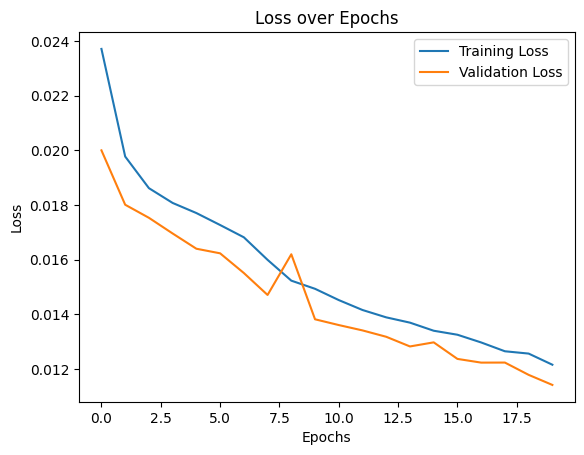

In [ ]:
# Step 11: Visualize the training process
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Step 12: Make predictions on test data
predictions = model.predict(X_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Reverse the scaling of predictions to compare with actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)


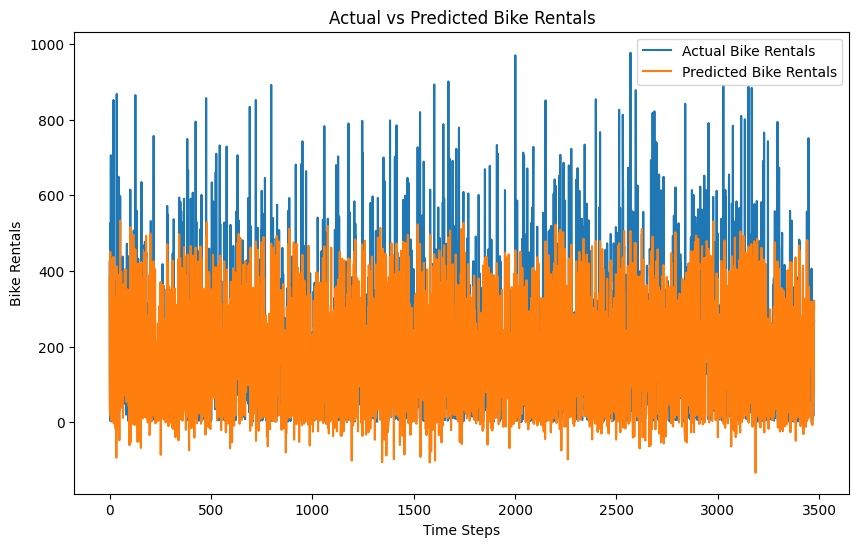

In [ ]:
# Step 13: Plot actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(y_test_inverse, label='Actual Bike Rentals')
plt.plot(predictions_inverse, label='Predicted Bike Rentals')
plt.title('Actual vs Predicted Bike Rentals')
plt.xlabel('Time Steps')
plt.ylabel('Bike Rentals')
plt.legend()
plt.show()